In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical")
ds = xr.open_dataset(basepath.joinpath("ds.zarr"))
ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ns")
da_s = compute(ds["s"], progress_flag=True)
dh = DataHandler.from_basepath_and_da(basepath.joinpath("results"), da_s)
exp = Experiment(dh)

/scratch/local/17138096/ipykernel_1504858/4264249769.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ns")


In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year"), pl.col("member")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "1d"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "1d"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "1d"),
    ).drop("year", "start", "end")
    return [seasons[["member", season]].explode(season).sort("member", season) for season in ["spring", "summer", "autumn"]]

In [4]:
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)
labels_kmeans["time"] = labels_kmeans.indexes["time"].to_datetimeindex(time_unit="ns")
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)

/scratch/local/17138096/ipykernel_1504858/2687002622.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  labels_kmeans["time"] = labels_kmeans.indexes["time"].to_datetimeindex(time_unit="ns")


In [5]:
members = summer["member"].unique().sort().to_numpy()
index = summer.to_pandas().set_index(["member", "summer"]).index
summer_da = dh.da.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)

In [18]:
import cf_xarray
cf_xarray.encode_multi_index_as_compress(summer_da.to_dataset()).to_netcdf("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/results/2/da.nc")

In [19]:
ds_ = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical/results/2/da.nc")

In [ ]:
cf_xarray.decode_compress_to_multi_index(xr.DataArray([1, 2]))

<xarray.Dataset> Size: 5GB
Dimensions:   (lat: 69, lon: 97, megatime: 191593)
Coordinates:
  * lat       (lat) float32 276B 15.55 16.49 17.43 18.38 ... 77.75 78.69 79.63
  * lon       (lon) float32 388B -80.0 -78.75 -77.5 -76.25 ... 37.5 38.75 40.0
  * megatime  (megatime) object 2MB MultiIndex
  * member    (megatime) <U12 9MB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time      (megatime) datetime64[ns] 2MB 1970-06-26T12:00:00 ... 2009-10-0...
Data variables:
    s         (megatime, lat, lon) float32 5GB ...

: 

: 

: 

In [81]:
dh_summer = DataHandler.from_basepath_and_da(exp.path.parent, summer_da, save_da=False)
exp_summer = Experiment(dh_summer)

In [95]:
dh_summer.da.indexes["lon"].nlevels

1

In [98]:
net, centers, labels = exp_summer.som_cluster(4, 4, 200, sigma=1.5, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), init="pca")

Memoized


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]


ValueError: unable to infer dtype on variable 'megatime'; xarray cannot serialize arbitrary Python objects

In [ ]:
X = []
for a, b in dt.items():
    b = b * np.sqrt(degcos(b.lat))
    b = b["s"].transpose("time", ...).values
    b = b.reshape(b.shape[0], -1)
    X.append(b)
X = np.concatenate(X)
pca = PCA(200).fit(X)
X = pca.transform(X)

In [ ]:
net = XPySom(
    4,
    4,
    PBC=True,
    activation_distance="euclidean",
    sigma=1.5,
    sigmaN=1e-5,
    init="pca",
)
net.train(X, num_epochs=20)
labels = net.predict(X)

PCA weights init


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


[########################################] | 100% Completed | 2.77 sms


In [62]:
labels = net.predict(X)

Memoized


In [64]:
labels

array([ 7,  7,  7, ...,  3, 15,  3])

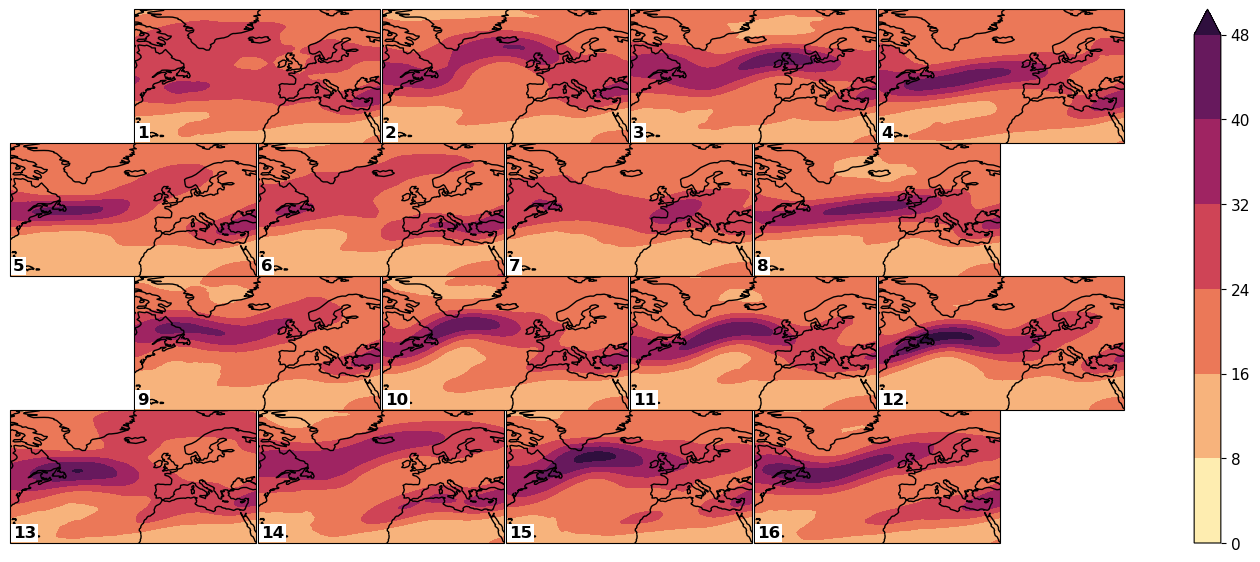

In [8]:
clu = Clusterplot(4, 4, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers, cmap=colormaps.matter, levels=7)

In [ ]:
from sklearn.metrics import pairwise_distances
from xpysom_dask.diagnostics import *
dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells = get_persistent_spell_times_from_som(labels, dists, sigma, 32, nt_before=8, nojune=True, daily=False)

In [ ]:
spells

spell,time,relative_index,value,len,relative_time
u32,datetime[ns],i16,i64,i64,duration[ns]
0,1959-06-12 12:00:00,-8,0,37,-2d
0,1959-06-12 18:00:00,-7,0,37,-1d -18h
0,1959-06-13 00:00:00,-6,0,37,-1d -12h
0,1959-06-13 06:00:00,-5,0,37,-1d -6h
0,1959-06-13 12:00:00,-4,0,37,-1d
…,…,…,…,…,…
114,2021-08-11 00:00:00,28,8,33,7d
114,2021-08-11 06:00:00,29,8,33,7d 6h
114,2021-08-11 12:00:00,30,8,33,7d 12h


(<Figure size 500x400 with 2 Axes>, <Axes: >)

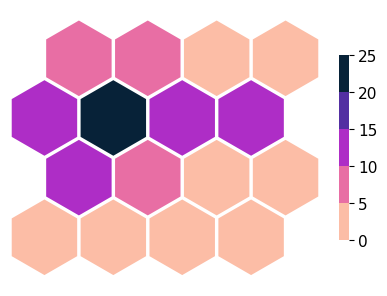

In [11]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
net.plot_on_map(spells_per_cluster["len"].to_numpy(), cmap=cmap, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

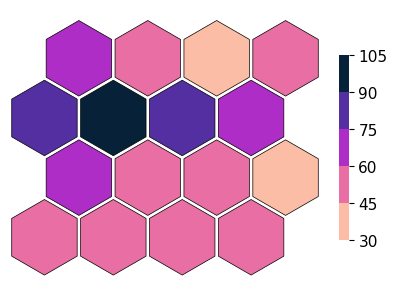

In [12]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max())
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

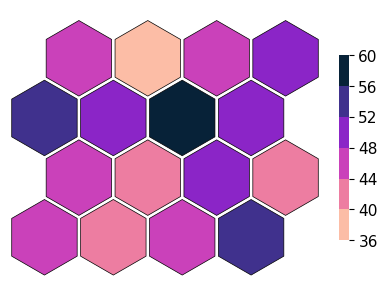

In [13]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

In [14]:
da_T = open_da("ERA5", "surf", "t", "6H", period=np.unique(labels["time"].dt.year).tolist(), minlon=-10, maxlon=40, minlat=30, maxlat=75, clim_type="dayofyear", clim_smoothing={'dayofyear': ('win', 15)})
da_T = da_T.sel(time=labels["time"].to_numpy())
da_T = compute(da_T, progress_flag=True)

[########################################] | 100% Completed | 87.16 s


100%|██████████| 16/16 [00:00<00:00, 26.77it/s]


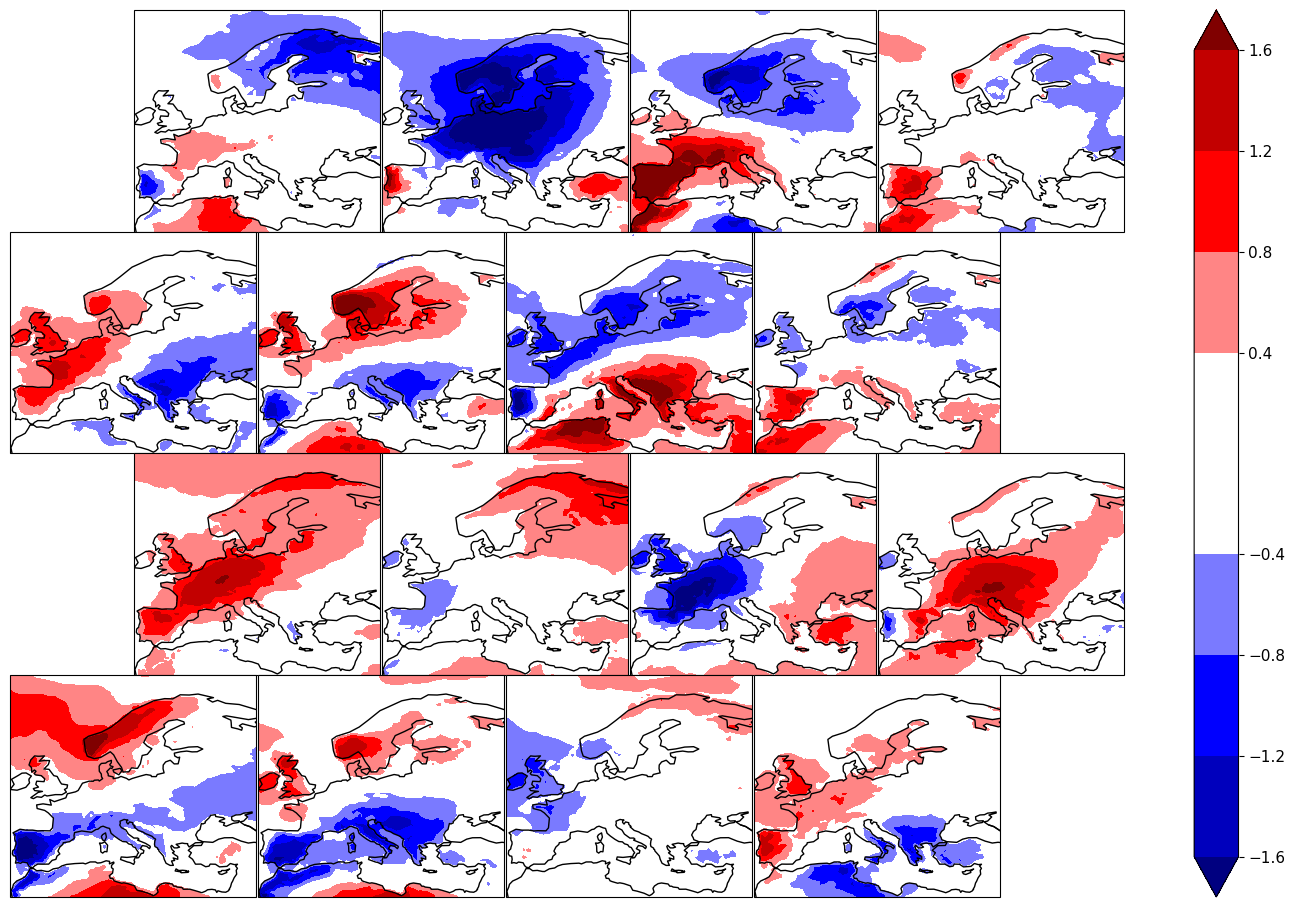

In [15]:
clu = Clusterplot(net.y, net.x, get_region(da_T), honeycomb=True)
_ = clu.add_any_contour_from_mask(da_T, labels_to_mask(labels), "contourf", cmap=colormaps.BlWhRe, levels=9)

In [16]:
# T_masked = mask_from_spells_pl(spells, da_T)

In [17]:
# T_masked_per_cluster = T_masked.groupby("value").mean("spell").rename({"value": "cluster"})
# u_clu = T_masked_per_cluster.cluster.values.astype(np.int32)
# to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
# indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
# T_masked_per_cluster = T_masked_per_cluster.sel(cluster=indexer)
# T_masked_per_cluster[to_zero, ...] = 0.
# T_masked_per_cluster = T_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

In [18]:
# numbering = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in np.arange(net.n_nodes)]
# clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T), numbering=numbering)
# _ = clu.add_contourf(T_masked_per_cluster.sel(relative_index=0), cmap=colormaps.BlWhRe, levels=18, q=1-1e-2)

In [69]:
exp_jets = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
props_as_df = exp_jets.props_as_df(True)
props_anoms = compute_anomalies_pl(props_as_df)
props_anoms_during_spells = mask_from_spells_pl(spells, props_anoms)
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
]

In [76]:
mean_props_during_spell = props_anoms_during_spells.filter(pl.col("relative_index") >= 0).group_by("value", "jet").agg(*[pl.col(col).mean() for col in data_vars], pl.col("len").mean()).sort("value", "jet")
quantiles = props_anoms.filter(
    pl.col("time").cast(pl.Datetime("ns")).is_in(labels.time.values)
).group_by("jet").agg(
    pl.concat_list(pl.col(col).quantile(.33), pl.col(col).quantile(.66)).alias(col) for col in data_vars
).with_columns(dummy=1).pivot(on="jet", index="dummy", values=data_vars).drop("dummy")
quantile_map = mean_props_during_spell.pivot(
    on="jet", index="value", values=data_vars
).join(quantiles, how="cross", suffix="_q").group_by("value", maintain_order=True).agg(
    pl.col(f"{col}_{jet}_q").explode().search_sorted(pl.col(f"{col}_{jet}")) for col in data_vars for jet in ["STJ", "EDJ"]
)


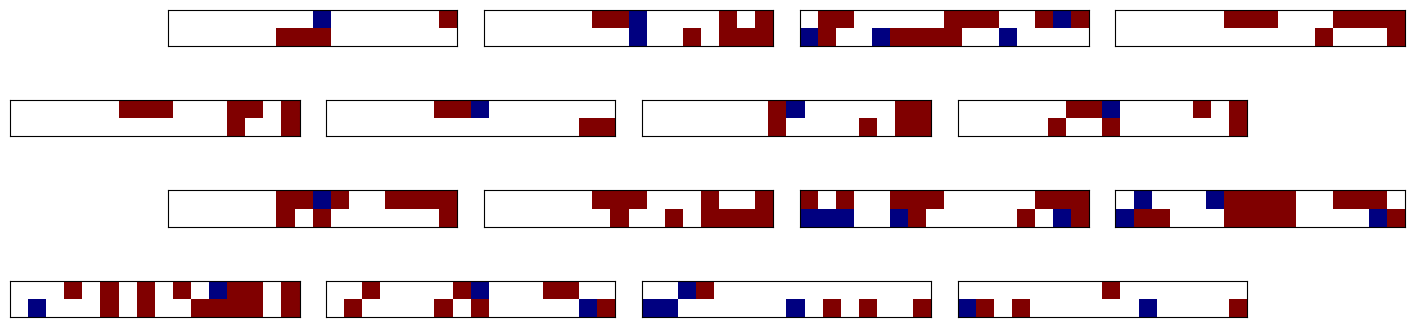

In [89]:
fig, axes = honeycomb_panel(net.y, net.x, subplot_kw={"aspect": "equal"}, hspace=.2, wspace=.2, ratio=.25)
axes = axes.ravel()
for i in range(net.n_nodes):
    ax = axes[i]
    to_plot = quantile_map[i].drop("value").to_numpy().reshape(16, 2).T
    ax.pcolormesh(to_plot, vmin=0, vmax=2, cmap=colormaps.BlWhRe)
    ax.set_xticks([])
    ax.set_yticks([])

## kmeans populations

In [15]:
weekly = labels.group_by(pl.col("time").dt.week().alias("week")).agg(pl.col("labels").unique(), pl.col("labels").unique_counts().alias("count")).explode("labels", "count").sort("week", "labels")
unique_weeks = weekly["week"].unique().to_frame()
unique_labels = weekly["labels"].unique().to_frame()
index = unique_weeks.join(unique_labels, how="cross")
weekly = index.join(weekly, on=index.columns, how="left").fill_null(0)

(0.0, 14268.800000000001)

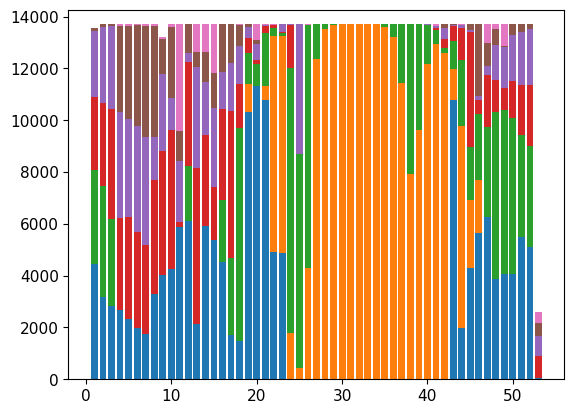

In [16]:
bottom = np.zeros(len(unique_weeks))
x = unique_weeks["week"].to_numpy()
fig, ax = plt.subplots()
for lab in unique_labels["labels"].to_numpy():
    y = weekly.filter(pl.col("labels") == lab)["count"]
    plt.bar(x, y, bottom=bottom)
    bottom = bottom + y
ax.set_ylim(0, bottom.max() * 1.04)

In [ ]:
monthly = xarray_to_polars(labels).group_by(pl.col("time").dt.month().alias("month")).agg(pl.col("labels").unique(), pl.col("labels").unique_counts().alias("count")).explode("labels", "count").sort("month", "labels")
unique_weeks = monthly["month"].unique().to_frame()
unique_labels = monthly["labels"].unique().to_frame()
index = unique_weeks.join(unique_labels, how="cross")
monthly = index.join(monthly, on=index.columns, how="left").fill_null(0)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 1 with shape (6,).

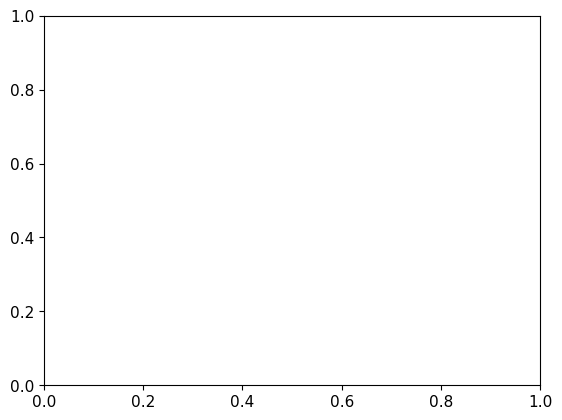

In [ ]:
bottom = np.zeros(12)
x = np.arange(12)
fig, ax = plt.subplots()
for lab in unique_labels["labels"].to_numpy():
    y = monthly.filter(pl.col("labels") == lab)["count"]
    plt.bar(x, y, bottom=bottom)
    bottom = bottom + y
ax.set_ylim(0, bottom.max() * 1.04)